In [1]:
# Load packages
import scipy
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [2]:
# Load top node information
nodes = pd.read_csv('annot_synthetic.tsv', sep='\t')
nr_nodes = len(nodes['node'])
nodes['node']

0    A
1    B
2    C
Name: node, dtype: object

In [4]:
# Load parameters for the top regulator of each target node

# Set up array structures
gamma_vect = np.empty((1,nr_nodes));
beta_vect  = np.empty((1,nr_nodes));
alpha_vect = np.empty((1,nr_nodes));
K_vect     = np.empty((1,nr_nodes));
n_vect     = np.empty((1,nr_nodes));
type_reg_list = [];
reg_nr_vect = np.empty((1,nr_nodes));

# Extract LEM parameters from top regulator of each target gene
for i in range(nr_nodes):
    name = nodes['node'][i]
    tsv_data = pd.read_csv("targets_lem/target_%s_ts0.tsv" % name,sep='\t',nrows = 1,skiprows = [0,1,2,3])
    tsv_np   = tsv_data.to_numpy()[0]
    type_reg_list.append(tsv_np[0][3])
    reg                = tsv_np[0][7:8] # modify the end of this range (8) to reflect the number of letters in the name of genes in your database
    gamma_vect[0,i]    = tsv_np[5] # basal expression rate
    beta_vect[0,i]     = tsv_np[6] # degradation rate
    alpha_vect[0,i]    = tsv_np[7] # max transcription rate
    K_vect[0,i]        = tsv_np[8] # threshold of regulator
    n_vect[0,i]        = tsv_np[9] # Hill coefficient
    reg_index = nodes.index[nodes['node'] == reg].tolist() # index of regulator gener
    for j in reg_index: # convert index of regulator gene to integer
        reg_nr_vect[0,i] = int(j)
        
# Correct size of vectors of parameters       
gamma_vect  = gamma_vect[0]
beta_vect   = beta_vect[0]
alpha_vect  = alpha_vect[0]
K_vect      = K_vect[0]
n_vect      = n_vect[0]
reg_nr_vect = reg_nr_vect[0].astype(int)

In [5]:
# Function that defines the right-hand-side of the system of ODEs
def vectorfield(x, t, nr_nodes,gamma,beta,alpha,K,n,type_reg,reg_nr):
    """
    Defines the differential equations for the system.
    Arguments:
        x :  vector of the state variables for all nodes
        t :  time
    """
    f = [];
    for i in range(nr_nodes):
        if type_reg[i]=='a': # activation
            ind = reg_nr[i]  # index of activator
            rhsa = gamma[i] - beta[i]*x[i] + alpha[i]*(x[ind]**n[i])/(x[ind]**n[i]+K[i]**n[i])
            f.append(rhsa)
        else:                # repression
            ind = reg_nr[i]  # index of repressor
            rhsr = gamma[i] - beta[i]*x[i] + alpha[i]*(K[i]**n[i])/(x[ind]**n[i]+K[i]**n[i])
            f.append(rhsr)
                
    return f

In [6]:
# Initial conditions

# # If you have time-series data:
# x0 = np.empty((1,nr_nodes));
# data_file = "RSEM_TPM_timeseries.tsv"
# data = pd.read_csv(data_file, sep='\t')
# for i in range(nr_nodes):
#     name = nodes['node'][i]
#     indx_data = data.index[data[data.columns[0]] == name]
#     data_node = data.loc[indx_data]
#     x0[0,i]   = data_node['0'].to_numpy()[0]
# x0 = x0[0]

# Here, know from synthetic network:
x0 = np.array([418,390,475])

In [7]:
# Solve the ODE model system

# ODE solver parameters
abserr    = 1.0e-8
relerr    = 1.0e-6
stoptime  = 200.0  # Final time of the data
numpoints = 100    # Number of timepoints at which you have data

# Create the time samples for the output of the ODE solver.
t = [stoptime * float(i) / (numpoints - 1) for i in range(numpoints)]

# Call the ODE solver.
xsol = odeint(vectorfield, x0, t, args=(nr_nodes,gamma_vect,beta_vect,alpha_vect,K_vect,n_vect,type_reg_list,reg_nr_vect),
              atol=abserr, rtol=relerr)

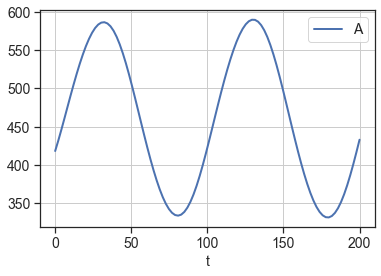

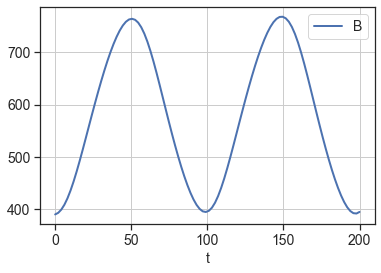

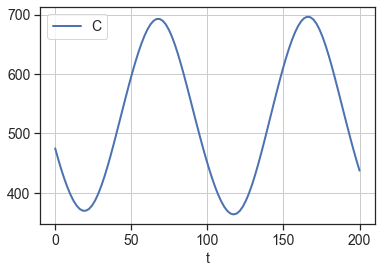

In [8]:
### Plotting solutions
from matplotlib import rc
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
import seaborn
seaborn.set(style='ticks')
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('axes', titlesize=14)

for i in range(nr_nodes): #range(0,1):
    name = nodes['node'][i]
    plt.figure()
    
#     # plot data (if have time-series data)
#     indx_data = data.index[data[data.columns[0]] == name]
#     data_node = data.loc[indx_data]
#     data_node.drop(data_node.columns[0],axis=1,inplace=True) # remove first column
#     plt.plot(t, data_node.to_numpy()[0], 'k', linewidth=2, label='data')
    
    # plot simulated ODE solution
    plt.plot(t, xsol[:,i], 'b', linewidth=2, label=name)
    
    plt.xlabel('t')
    plt.grid(True)
    plt.legend(fontsize=14)